# Tap dependent impedance of transformers

With an adjustment of a tap position of a transformer, the number of windings is adjusted, which influences the impedance. The user can provide characteristics of the dependance of the variables vk_percent and vkr_percent on the tap position. A helper function in pandapower toolbox converts the provided points in a scipy.interpolate.interp1 object and writes it in the trafo table.

In [1]:
import pandapower as pp
from pandapower.control.util.auxiliary import plot_characteristic
from pandapower.control import TapDependentImpedance

In [2]:
def create_net():
    net = pp.create_empty_network()
    vn_kv = 20
    b1 = pp.create_bus(net, vn_kv=vn_kv)
    pp.create_ext_grid(net, b1, vm_pu=1.01)
    b2 = pp.create_bus(net, vn_kv=vn_kv)
    l1 = pp.create_line_from_parameters(net, b1, b2, 12.2, r_ohm_per_km=0.08, x_ohm_per_km=0.12,
                                              c_nf_per_km=300, max_i_ka=.2, df=.8)
    b3 = pp.create_bus(net, vn_kv=0.4)
    b4 = pp.create_bus(net, vn_kv=0.4)
    pp.create_transformer(net, hv_bus=b2, lv_bus=b3, std_type="0.25 MVA 20/0.4 kV", tap_pos=2)
    pp.create_transformer(net, hv_bus=b2, lv_bus=b4, std_type="0.25 MVA 20/0.4 kV", tap_pos=2)
    pp.create_load(net, b3, 0.2, 0.05)
    pp.create_load(net, b4, 0.2, 0.05)
    return net

In [3]:
net = create_net()

We can create the characteristics for vk_percent and vkr_percent:

In [4]:
pp.toolbox.create_trafo_characteristics(net, 'trafo', [0], [[-2, -1, 0, 1, 2]], [[5, 5.2, 6, 6.8, 7]],
                                            [[-2, -1, 0, 1, 2]], [[1.3, 1.4, 1.44, 1.5, 1.6]])

Let us check the characteristic:

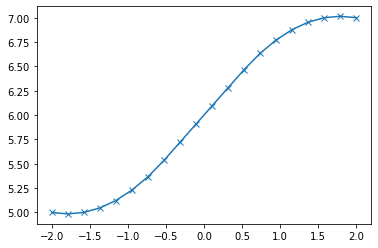

In [5]:
plot_characteristic(net.trafo.at[0, 'vk_percent_characteristic'], -2, 2)

plot_characteristic(net.trafo.at[0, 'vkr_percent_characteristic'], -2, 2)

In [6]:
pp.runpp(net)

Let us verify that the adjusted values were considered in the calculation:

In [7]:
net.res_bus.loc[[2,3]]

,vm_pu,va_degree,p_mw,q_mvar
2,0.931359,-3.390736,0.2,0.05
3,0.935414,-2.890645,0.2,0.05


Now let us compare the computation time

In [8]:
net2 = create_net()

In [9]:
%timeit pp.runpp(net2)

8.45 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit pp.runpp(net)

8.7 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The calculation with tap dependent impedance is about 4 percent slower

Now, let us compare the performance of the controller for reference

In [11]:
net3 = create_net()
TapDependentImpedance(net3, [0], net.trafo.at[0, 'vk_percent_characteristic'], output_variable="vk_percent")
TapDependentImpedance(net3, [0], net.trafo.at[0, 'vkr_percent_characteristic'], output_variable="vkr_percent");

In [12]:
%timeit pp.runpp(net3, run_control=True)

30 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The computational time is 3,3 times higher!

The results are identical:

In [13]:
net3.res_bus.loc[[2,3]]

,vm_pu,va_degree,p_mw,q_mvar
2,0.931359,-3.390736,0.2,0.05
3,0.935414,-2.890645,0.2,0.05


# Further work:

* implementation for trafo3w (only possible with the controller now)
* further testing
* file I/O with the new implementation